In [4]:
# Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/naf/'
''' If SSL error _ssl.c:997: 
    pip install --upgrade certifi'''

tjy_udf:  ['CalcF', 'H_find', 'Heights', 'Kap_D', 'elread', 'get_fp', 'get_fs', 'git_sync', 'lighten_color', 'phread', 'phreadxyz', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


' If SSL error _ssl.c:997: \n    pip install --upgrade certifi'

In [2]:
def Process(fname):
    data = pd.read_csv(fname, names=np.arange(12), sep='\s+')
    thetas, nd = [], []
    for i in range(len(data)):
        if i%2: thetas += [data.iloc[i,5]] # Vol dens of block 2 adj. to surf
        else:   nd += [data.iloc[i,:6].to_list()]
    return pd.concat([pd.DataFrame(nd,  columns=['it', 'lx', 'free', 'freeDiff', 'inCompMax', 'andErr']), pd.Series(thetas, name='theta')], axis=1)

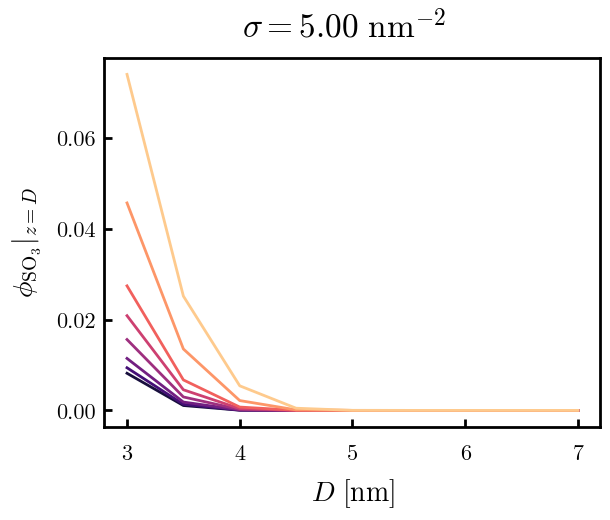

In [23]:
lx30, lx35, lx40, lx45 = Process(GIT+'s500_lx30.txt'), Process(GIT+'s500_lx35.txt'), Process(GIT+'s500_lx40.txt'), Process(GIT+'s500_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s500_lx50.txt'), Process(GIT+'s500_lx55.txt'), Process(GIT+'s500_lx60.txt'), Process(GIT+'s500_lx65.txt'), Process(GIT+'s500_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

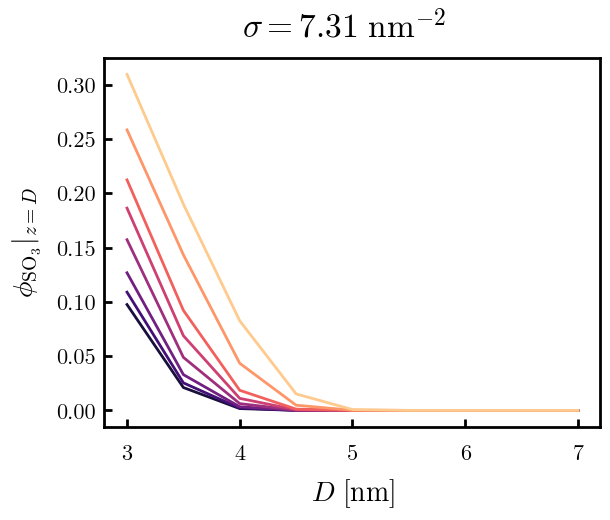

In [22]:
lx30, lx35, lx40, lx45 = Process(GIT+'s731_lx30.txt'), Process(GIT+'s731_lx35.txt'), Process(GIT+'s731_lx40.txt'), Process(GIT+'s731_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s731_lx50.txt'), Process(GIT+'s731_lx55.txt'), Process(GIT+'s731_lx60.txt'), Process(GIT+'s731_lx65.txt'), Process(GIT+'s731_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

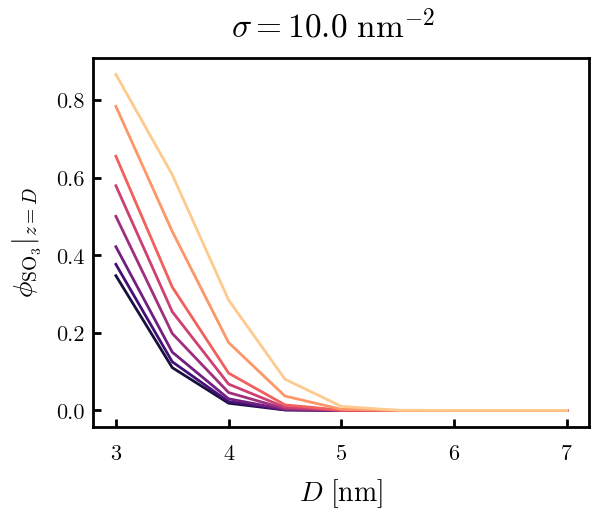

In [21]:
lx30, lx35, lx40, lx45 = Process(GIT+'s1000_lx30.txt'), Process(GIT+'s1000_lx35.txt'), Process(GIT+'s1000_lx40.txt'), Process(GIT+'s1000_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s1000_lx50.txt'), Process(GIT+'s1000_lx55.txt'), Process(GIT+'s1000_lx60.txt'), Process(GIT+'s1000_lx65.txt'), Process(GIT+'s1000_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

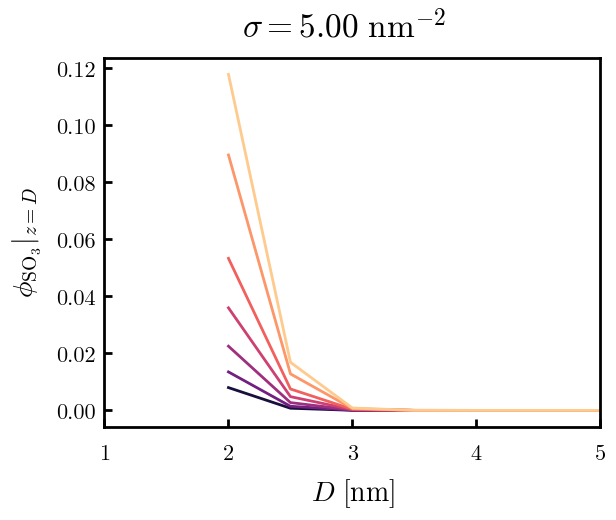

In [45]:
cs = 'c100_'
ss = 's500_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim = (1, 5)
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

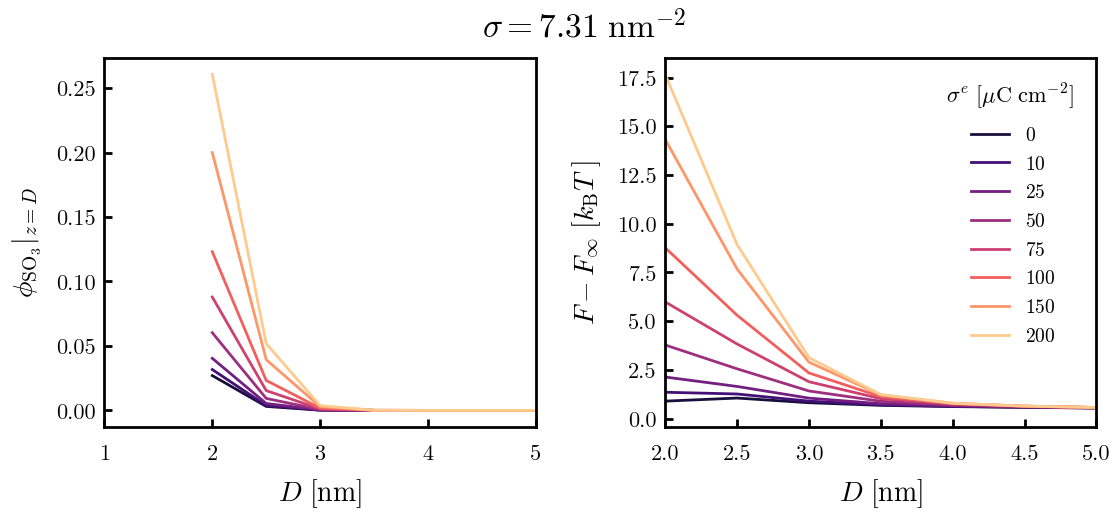

In [69]:
cs,cbulk = 'c100_', 0.1 * 1000 * 6.02e23 / 1e27
ss = 's731_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,2, figsize=(mpl.rcParams['figure.figsize'][0]*2, mpl.rcParams['figure.figsize'][1]))
# ax = [ax]
plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = np.array([i.lx[0] for i in lxs])
    y = [i.free[ind] for i in lxs]
    ax[1].plot(x, y-y[-1] + cbulk*x, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim= (1, 5)
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
ax[1].legend(loc=(0.69,0.20), ncol=1)

ax[1].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlim= (2, 5)
)
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

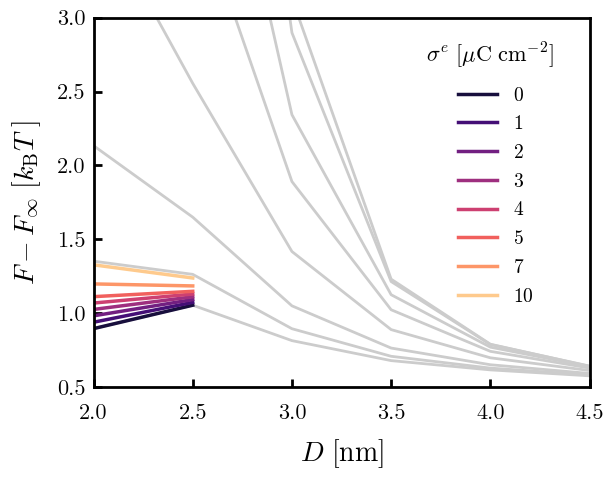

In [75]:
bulk = lx70
for ind,i in enumerate(surfs):
    x = np.array([i.lx[0] for i in lxs])
    y = [i.free[ind] for i in lxs]
    plt.plot(x, y-bulk.free[ind] + cbulk*x, label='_${}$'.format(i), color='0.8')
    
kws = {'names':['it', 'lx', 'free', 'x', 'xx', 'xxx'], 'sep':'\s+'}
data = pd.read_csv(GIT+'new-lx15.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')
data1= pd.read_csv(GIT+'new-lx20.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')
data2= pd.read_csv(GIT+'new-lx25.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')

for ind,i in enumerate([0,1,2,3,4,5,7,10]):
    x=np.array([i.lx[0] for i in [data, data1, data2]])[1:3]
    y=[i.free[ind] for i in [data,data1,data2]][1:3]
    plt.plot(x,y-bulk.free[0]+cbulk*x, label='${}$'.format(i), color=mcs[ind], marker='', lw=2.5)
    
plt.gca().set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlim=(2,4.5),
    ylim=(0.5,3)
)
plt.text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=plt.gca().transAxes, fontsize=16, ha='center')
plt.legend(loc=(0.72,0.2))
tjy.ticks()

In [99]:
lx25fs = pd.DataFrame([
    [0,  2.500e+00, -4.70644e+01, 1.42445e-01, -5.70074e+01, -1.00664e+01, 2.01681e+01, -3.01100e-01],
    [1,  2.500e+00, -4.70453e+01, 1.42697e-01, -5.69071e+01, -1.01076e+01, 2.01279e+01, -3.01100e-01],
    [2,  2.500e+00, -4.70263e+01, 1.42951e-01, -5.68055e+01, -1.01494e+01, 2.00867e+01, -3.01100e-01],
    [3,  2.500e+00, -4.70075e+01, 1.43208e-01, -5.67026e+01, -1.01915e+01, 2.00445e+01, -3.01100e-01],
    [4,  2.500e+00, -4.69889e+01, 1.43469e-01, -5.65984e+01, -1.02342e+01, 2.00013e+01, -3.01100e-01],
    [5,  2.500e+00, -4.69705e+01, 1.43732e-01, -5.64929e+01, -1.02772e+01, 1.99570e+01, -3.01100e-01],
    [7,  2.500e+00, -4.69340e+01, 1.44269e-01, -5.62778e+01, -1.03647e+01, 1.98653e+01, -3.01100e-01],
    [10, 2.500e+00, -4.68804e+01, 1.45097e-01, -5.59451e+01, -1.04994e+01, 1.97200e+01, -3.01100e-01],
], columns=['surf', 'lx', 'free', 'U', 'W', 'S', 'elec', 'bulk'])
lx20fs = pd.DataFrame([
    [0,  2.000e+00, -4.71928e+01, 1.34811e-01, -7.39004e+01, 7.12726e+00, 1.96863e+01, -2.40880e-01],
    [1,  2.000e+00, -4.71495e+01, 1.35207e-01, -7.36954e+01, 7.04242e+00, 1.96091e+01, -2.40880e-01],
    [2,  2.000e+00, -4.71062e+01, 1.35607e-01, -7.34882e+01, 6.95684e+00, 1.95305e+01, -2.40880e-01],
    [3,  2.000e+00, -4.70629e+01, 1.36010e-01, -7.32789e+01, 6.87055e+00, 1.94503e+01, -2.40880e-01],
    [4,  2.000e+00, -4.70197e+01, 1.36418e-01, -7.30675e+01, 6.78354e+00, 1.93687e+01, -2.40880e-01],
    [5,  2.000e+00, -4.69765e+01, 1.36829e-01, -7.28539e+01, 6.69581e+00, 1.92856e+01, -2.40880e-01],
    [7,  2.000e+00, -4.68903e+01, 1.37662e-01, -7.24202e+01, 6.51825e+00, 1.91149e+01, -2.40880e-01],
    [10, 2.000e+00, -4.67612e+01, 1.38939e-01, -7.17533e+01, 6.24658e+00, 1.88475e+01, -2.40880e-01], 
], columns=['surf', 'lx', 'E', 'U', 'W', 'S', 'elec', 'bulk'])
pd.concat([lx20fs, lx25fs])

,surf,lx,E,U,W,S,elec,bulk,free
0,0,2.0,-47.1928,0.134811,-73.9004,7.12726,19.6863,-0.24088,NaN
1,1,2.0,-47.1495,0.135207,-73.6954,7.04242,19.6091,-0.24088,NaN
2,2,2.0,-47.1062,0.135607,-73.4882,6.95684,19.5305,-0.24088,NaN
3,3,2.0,-47.0629,0.136010,-73.2789,6.87055,19.4503,-0.24088,NaN
4,4,2.0,-47.0197,0.136418,-73.0675,6.78354,19.3687,-0.24088,NaN
5,5,2.0,-46.9765,0.136829,-72.8539,6.69581,19.2856,-0.24088,NaN
6,7,2.0,-46.8903,0.137662,-72.4202,6.51825,19.1149,-0.24088,NaN
7,10,2.0,-46.7612,0.138939,-71.7533,6.24658,18.8475,-0.24088,NaN
0,0,2.5,NaN,0.142445,-57.0074,-10.06640,20.1681,-0.30110,-47.0644
1,1,2.5,NaN,0.142697,-56.9071,-10.10760,20.1279,-0.30110,-47.0453


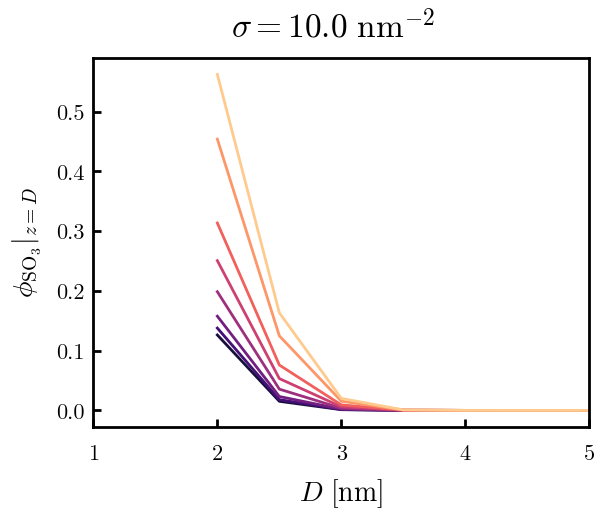

In [48]:
cs = 'c100_'
ss = 's1000_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim= (1, 5),
    # yscale= 'log',
    # ylim= (1e-03, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

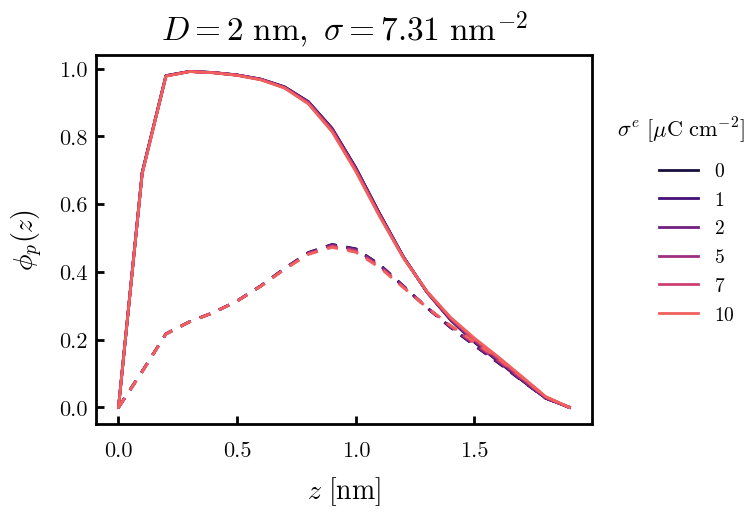

In [93]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'ph_new-lx200e'

fig, ax = plt.subplots(1,1)
for i,c in zip(['000', '001', '002', '005', '007', '010'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
    
# ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
# ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    # xlim= (1.4, 1.8),
    # ylim= (0, 0.30),
)    

ax.text(1.18, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.12,0.25), ncol=1)

plt.title(r'$D=2\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks()

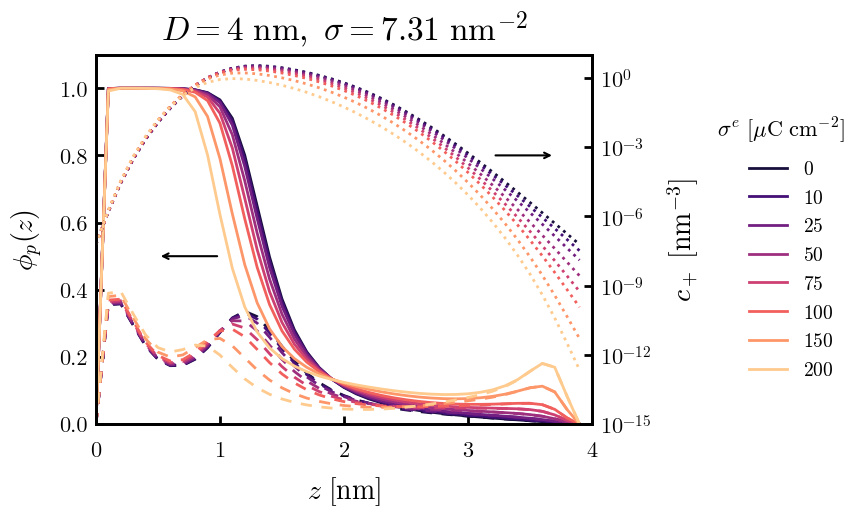

In [68]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731_lx400e'
eat = 'els731_lx400e'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+'.dat')
    rax.plot(el.z, el.an,c=c, ls=':')
    
ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (0, 4),
    ylim= (0, 1.10),
)    
rax.set(
    yscale='log',
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (1e-15, 1e1)
)
ax.text(1.38, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.10), ncol=1)

plt.title(r'$D=4\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks([ax, rax])

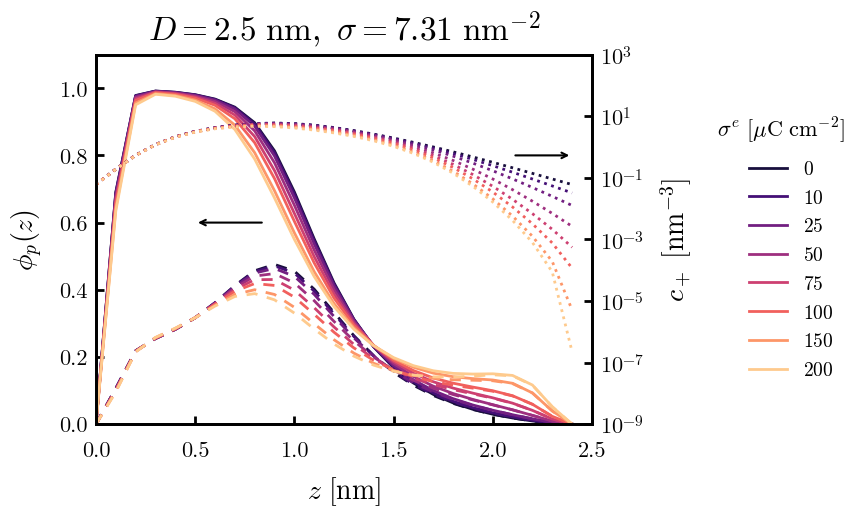

In [77]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731c100_lx250e'
eat = 'els731c100_lx250e'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+'.dat')
    rax.plot(el.z, el.an,c=c, ls=':')
    
ax.annotate("", xy=(0.50, 0.6), xytext=(0.85, 0.6),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.annotate("", xy=(2.4, 0.8), xytext=(2.1, 0.8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (0, 2.5),
    ylim= (0, 1.10),
)    
rax.set(
    yscale='log',
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (1e-9, 1e3)
)
ax.text(1.38, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.10), ncol=1)

plt.title(r'$D=2.5\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks([ax, rax])